In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os 
import pickle
import timeit
import math
import time
import sparse
import dask
import dask.array as da
from dask.diagnostics import ProgressBar
from scipy import interpolate
from pylab import *
from numpy import *
from glob import glob
from os import path
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm, rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
import seaborn as sns

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir']= os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point

import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from copy import copy

plt.ion()  # To trigger the interactive inline mode

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
outputDir = 'data/posterior_computation_data/'
outputgraphsDir = outputDir + 'graphs/'
gom_masks = xr.open_dataset(outputDir + 'gom_masks.nc')

# GLOBAL CONSTANTS
MIN_LON = np.min(gom_masks['lon'].values)
MAX_LON = np.max(gom_masks['lon'].values)
MIN_LAT = np.min(gom_masks['lat'].values)
MAX_LAT = np.max(gom_masks['lat'].values)

#domain width and height (cell counts)
LAT_SIZE = gom_masks.dims['lat']
LON_SIZE = gom_masks.dims['lon']

#cell size
D_LON = gom_masks["lon"][1].values - gom_masks["lon"][0].values
D_LAT = gom_masks["lat"][1].values - gom_masks["lat"][0].values

BIN_CELL_LATS = gom_masks.bin_cell_lats.values
BIN_CELL_LONS = gom_masks.bin_cell_lons.values

MIN_LON, MAX_LON, MIN_LAT, MAX_LAT,LAT_SIZE,LON_SIZE, D_LON,D_LAT

(-97.98001098632812,
 -76.45999145507812,
 18.140000343322754,
 31.899998664855957,
 345,
 539,
 0.03997802734375,
 0.03999900817871094)

In [3]:
# Load domain_cell_tree
fileObj = open(outputDir + 'output_dict.obj', 'rb')
output_dict = pickle.load(fileObj)
fileObj.close()

In [4]:
## n_cell_beaching = output['n_cell_beaching']
n_cell_source = output_dict['n_cell_source']
n_window_beaching = output_dict['n_window_beaching'] 
n_window_source = output_dict['n_window_source']
n_cell_beaching = output_dict['n_cell_beaching']

source_cell_mask = output_dict['source_cell_mask']

n_cell_beaching,n_cell_source,n_window_beaching, n_window_source

(188, 114024, 30, 36)

In [5]:
# Load agg values
fileObj = open(outputDir + 'agg_dict.obj', 'rb')
output_agg = pickle.load(fileObj)
fileObj.close()

group_source_region_names = output_agg['group_source_region_names']

In [6]:
# Load All Data

#############
Figure_11_l_raw = xr.load_dataset(outputDir + 'Figure_11_l_raw.nc')
Figure_11_l_vals = Figure_11_l_raw.l_n_post.values 

Figure_11_l = np.zeros((LAT_SIZE, LON_SIZE))
Figure_11_l[source_cell_mask] = Figure_11_l_vals *100
#############

#############
Figure_11_r_raw = xr.load_dataset(outputDir + 'Figure_11_r_raw.nc')
Figure_11_r_vals = Figure_11_r_raw.r_n_post.values

Figure_11_r = np.zeros((LAT_SIZE, LON_SIZE))
Figure_11_r[source_cell_mask] = Figure_11_r_vals *100
#############

#############
Figure_11_f_raw = xr.load_dataset(outputDir + 'Figure_11_f_raw.nc')
Figure_11_f_vals = Figure_11_f_raw.f_n_post.values

Figure_11_f = np.zeros((LAT_SIZE, LON_SIZE))
Figure_11_f[source_cell_mask] = Figure_11_f_vals*100
#############

#############
Figure_11_raw = xr.load_dataset(outputDir + 'Fig11_greyscale.nc')
Figure_11_vals = Figure_11_raw.__xarray_dataarray_variable__.values

Figure_11 = np.zeros((LAT_SIZE, LON_SIZE))
Figure_11[source_cell_mask] = Figure_11_vals*100
#############

Fig9 = xr.load_dataset(outputDir + 'Fig9.nc')
Fig9_vals = Fig9.__xarray_dataarray_variable__.values*100
Fig9_gs_region = (Fig9.group_source_region.values.astype(int) - 1)
Fig9_gb_region = (Fig9.group_beaching_region.values.astype(int) - 1)

Fig13 = xr.load_dataset(outputDir + 'Fig13.nc')
Fig13_vals = Fig13.__xarray_dataarray_variable__.values*100

prior = xr.open_dataset(outputDir + 'prior.nc')

l_prior = prior.l_prior.values * 100
r_prior = prior.r_prior.values * 100
f_prior = prior.f_prior.values * 100

In [71]:
top_river = int(np.argmax(Figure_11_r_vals))
tr_x, tr_y =source_cell_mask[0][top_river], source_cell_mask[1][top_river]
print('Grijalva River:', Figure_11_r[tr_x, tr_y])

Grijalva River: 4.255320120148835


In [47]:
# Galveston Bay (29.34, -94.56)
# New Orleans (29.58, -90.04)
# Tampa (27.56 -82.27)
#Corpus Christi (27.44, 97.24)
# Mérida, Yucatán (20.58, -89.37) 
# Frontera, Tabasco (18.32 -92.38)

# Grijalva River
# Pearl River

major_city_lats = [29.4, 27.44, 29.98, 27.56, 20.58, 18.32]
major_city_lons = [-94.68, -97.24, -90.0, -82.27, -89.37, -92.4]
major_city_names = ['Galveston Bay', 'Corpus Christi', 'New Orleans', 'Tampa', 'Mérida', 'Frontera']
major_city_hl = ['right', 'right', 'right', 'left','left', 'left']
major_city_vl = ['bottom', 'top', 'bottom', 'bottom','top', 'top']

major_city_df = { 'major_city_names': major_city_names, 'lats': major_city_lats, 'lons': major_city_lons, 
                 'major_city_hl': major_city_hl, 'major_city_vl': major_city_vl}
major_city_df = pd.DataFrame(major_city_df)

Overall Proportions

In [16]:
l_prior_prop, r_prior_prop, f_prior_prop = np.sum(l_prior), np.sum(r_prior), np.sum(f_prior)
print('Posterior Proportions | Land', l_prior_prop, ' | River', r_prior_prop, '| Fishing ', f_prior_prop)

l_post_prop, r_post_prop, f_post_prop = np.sum(Figure_11_l), np.sum(Figure_11_r), np.sum(Figure_11_f)
print('Posterior Proportions | Land', l_post_prop, ' | River', r_post_prop, '| Fishing ', f_post_prop)

Posterior Proportions | Land 51.99950886829463  | River 28.000491131705445 | Fishing  20.000000000000018
Posterior Proportions | Land 45.97915236447743  | River 12.198145468314763 | Fishing  41.742799997248156


Prior

In [17]:
prior_mpw = xr.open_dataset(outputDir + 'prior_mpw.nc')

land_input = prior_mpw.land_input.mean(dim = 'time').values
river_input = prior_mpw.river_input.mean(dim = 'time').values
fishing_input = prior_mpw.fishing_input.mean(dim = 'time').values

/home/dpojunas/.conda/envs/py3_parcels/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: Log scale: values of z <= 0 have been masked
  result = super().contourf(*args, **kwargs)


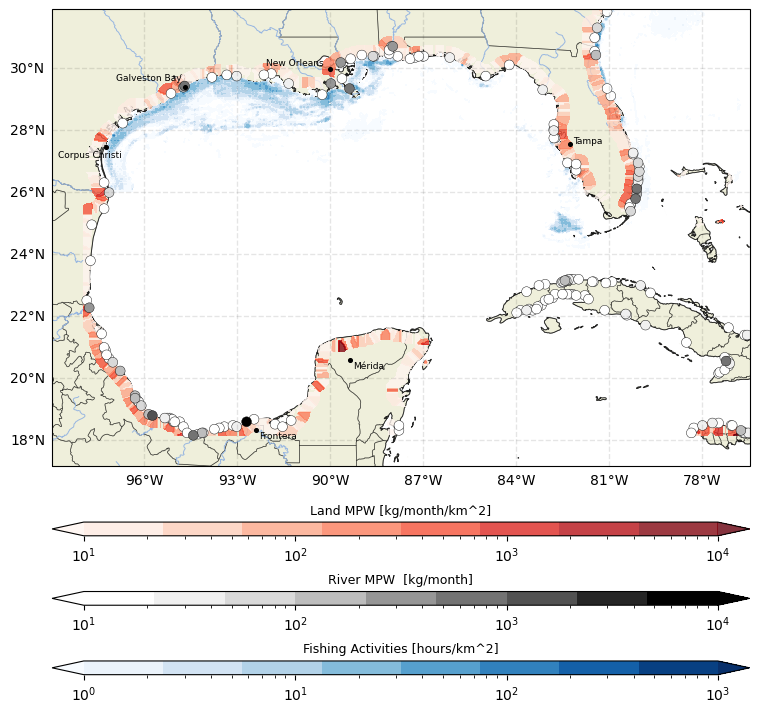

In [52]:
# plotting settings

fig = plt.figure(figsize=(9,10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.1, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Geospatial Features
ax.add_feature(cfeature.LAND, zorder=1,)
ax.add_feature(cfeature.COASTLINE, linewidth=0.7, zorder=1, alpha = 0.7)
ax.add_feature(cfeature.STATES, linewidth=0.5, zorder=1, alpha = 0.5)
ax.add_feature(cfeature.RIVERS, linewidth=0.7, zorder=1,  alpha = 1.0)

ax.set_extent([MIN_LON - 1,MAX_LON, MIN_LAT -1, MAX_LAT], ccrs.PlateCarree())

# Major Cities
plt.scatter(major_city_df.lons, major_city_df.lats, color = 'black', s = 7, zorder=11)
# add labels to all points
for i in range(len(major_city_df)):
    if (major_city_df.major_city_names.iloc[i] == 'New Orleans'):
        plt.text(major_city_df.lons.iloc[i]-0.21, major_city_df.lats.iloc[i]+0.05, 
             major_city_df.major_city_names.iloc[i], size = 6.5, rotation_mode =  'anchor',
             va=major_city_df.major_city_vl.iloc[i], 
             ha=major_city_df.major_city_hl.iloc[i], zorder=11)
    elif (major_city_df.major_city_names.iloc[i] == 'Galveston Bay'):
        plt.text(major_city_df.lons.iloc[i]-0.11, major_city_df.lats.iloc[i]+0.15, 
             major_city_df.major_city_names.iloc[i], size = 6.5, rotation_mode =  'anchor',
             va=major_city_df.major_city_vl.iloc[i], 
             ha=major_city_df.major_city_hl.iloc[i], zorder=11)
    elif (major_city_df.major_city_names.iloc[i] == 'Corpus Christi'):
        plt.text(major_city_df.lons.iloc[i]+0.50, major_city_df.lats.iloc[i]-0.1, 
             major_city_df.major_city_names.iloc[i], size = 6.5, rotation_mode =  'anchor',
             va=major_city_df.major_city_vl.iloc[i], 
             ha=major_city_df.major_city_hl.iloc[i], zorder=11)
    else:
        plt.text(major_city_df.lons.iloc[i]+0.1, major_city_df.lats.iloc[i]-0.05, 
             major_city_df.major_city_names.iloc[i], size = 6.5, rotation_mode =  'anchor',
             va=major_city_df.major_city_vl.iloc[i], 
             ha=major_city_df.major_city_hl.iloc[i], zorder=11)
    
# Custom Features
num_colors = 9
cmap_r = plt.get_cmap('Greys', num_colors)

lon_vals, lat_vals = np.meshgrid(gom_masks['lon'], gom_masks['lat'])

levels_mpw = np.logspace(np.log10(10), np.log10(10_000), 9)
levels_fish = np.logspace(np.log10(1), np.log10(1_000), 9)

# fishing
f = ax.contourf(lon_vals, lat_vals, fishing_input, levels = levels_fish, 
                norm=colors.LogNorm(), extend='both', cmap = plt.cm.Blues, alpha = 1.0, )

# land
within_25km_idx = np.where(~np.isnan(gom_masks.plotcoastidx))
ci25 = np.array(gom_masks.plotcoastidx.values[within_25km_idx], dtype = int)
idx_coast_mask = np.where(gom_masks.coastalmask == 1)
limgm = land_input[idx_coast_mask]
vals_within_25km = np.zeros( (gom_masks.dims['lat'], gom_masks.dims['lon']) ) * np.nan
vals_within_25km[within_25km_idx] = limgm[ci25]

land = ax.contourf(lon_vals, lat_vals, vals_within_25km, levels = levels_mpw, norm=colors.LogNorm(), extend='both', cmap = plt.cm.Reds,  alpha = 0.8,)

# river
r_lat_idx, r_lon_idx = np.where(river_input > 0.0)
r_Y, r_X, r_Z = gom_masks.lat[r_lat_idx].values, gom_masks.lon[r_lon_idx].values, river_input[r_lat_idx, r_lon_idx] 

# replot top 25 rivers for visibility
df = {'lat': r_Y, 'lon': r_X, 'val': r_Z}
df = pd.DataFrame(df)
df = df.sort_values(by = 'val', ascending = False)

reduced_df = df[df.val >= 1]
reduced_df = reduced_df.sort_values(by = 'val', ascending = True)

river = ax.scatter(reduced_df.lon, reduced_df.lat, c = reduced_df.val, s = 50, 
                   norm=colors.LogNorm(vmin=10, vmax=10_000), alpha = 1.0, cmap = cmap_r, edgecolors='black', linewidths = 0.3)


# Plot colorbars
axins_l = inset_axes(ax,
                    width="100%",  
                    height="3%",
                    loc='lower center',
                    borderpad=-5
                   )

axins_l.set_title('Land MPW [kg/month/km^2]', fontsize = 9)
fig.colorbar(land, cax=axins_l, orientation="horizontal", extend='both', ticks = [10, 100, 1000, 10000])
axins_l.minorticks_on()

axins_r = inset_axes(ax,
                    width="100%",  
                    height="3%",
                    loc='lower center',
                    borderpad=-10
                   )

axins_r.set_title('River MPW  [kg/month]', fontsize = 9)
fig.colorbar(river, cax=axins_r, orientation="horizontal", extend='both', ticks = [1, 10, 100, 1000, 10000,])
axins_r.minorticks_on()

axins_f = inset_axes(ax,
                    width="100%",  
                    height="3%",
                    loc='lower center',
                    borderpad=-15
                   )

axins_f.set_title('Fishing Activities [hours/km^2]', fontsize = 9)
fig.colorbar(f, cax=axins_f, orientation="horizontal",extend='both', ticks = [1, 10, 100, 1000])
axins_f.minorticks_on()

plt.savefig(outputgraphsDir + 'prior_input_map.png')

Figure 9

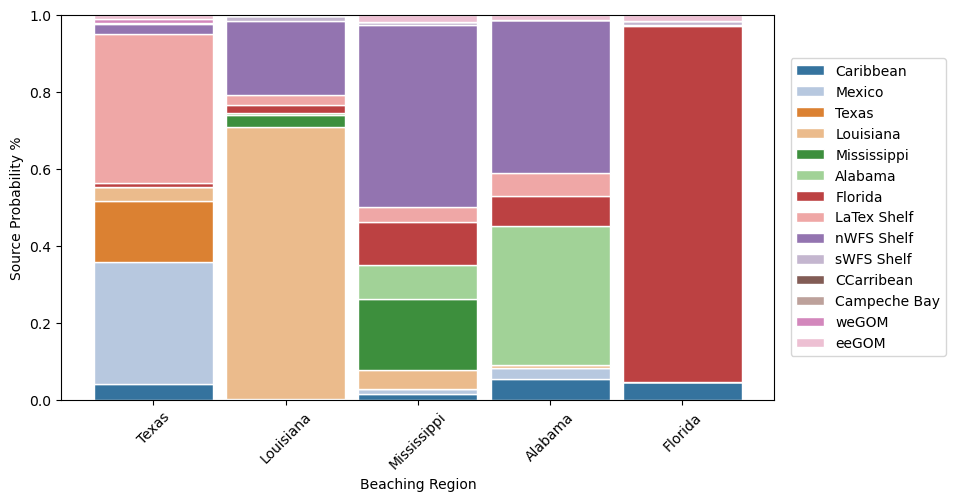

In [12]:
category_names_fig9 = group_source_region_names[Fig9_gs_region]
# since vals are 0.9999, I have just adjusted them to exactly one, and the plot looks better this way
results_fig9 = {(i+1): Fig9_vals.T[i]/np.sum( Fig9_vals.T[i]) for i in range(np.shape(Fig9_vals)[1])}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = sns.color_palette("tab20", 15, desat = 0.7)

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.yaxis.set_visible(True)
    ax.set_ylim(0, np.sum(data, axis=1).max())
    ax.set_ylabel("Source Probability %")
    
    ax.set_xlabel('Beaching Region')


    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.bar(labels, widths, bottom=starts,width = 0.9, label=colname, color=color, edgecolor='white',)
    legend = ax.legend(ncols=1, bbox_to_anchor=(1.25, 0.5), loc='right', fontsize='medium')

    return fig, ax, legend


fig, ax, legend = survey(results_fig9, category_names_fig9)

labels = group_source_region_names[Fig9_gb_region]
x = [i for i in range(1, len(labels)+1)]

plt.xticks(x, labels, rotation=45)

plt.savefig(outputgraphsDir + 'beaching_region_source_prob.png')

Figure 11

/home/dpojunas/.conda/envs/py3_parcels/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: Log scale: values of z <= 0 have been masked
  result = super().contourf(*args, **kwargs)


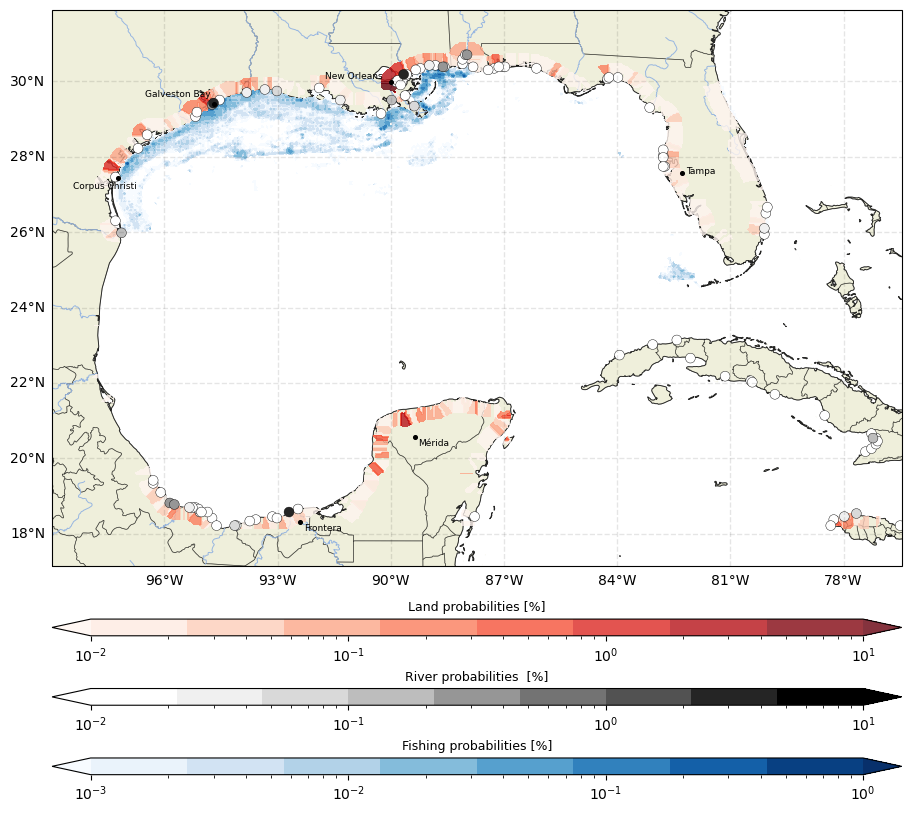

In [54]:
# plotting settings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import ScalarFormatter

fig = plt.figure(figsize=(9,10), constrained_layout = True)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.1, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_extent([MIN_LON - 1,MAX_LON, MIN_LAT -1, MAX_LAT], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=1,)
ax.add_feature(cfeature.COASTLINE, linewidth=0.7, zorder=1, alpha = 0.7)
ax.add_feature(cfeature.STATES, linewidth=0.5, zorder=1, alpha = 0.5)
ax.add_feature(cfeature.RIVERS, linewidth=0.7, zorder=1,  alpha = 1.0)

# Major Cities
plt.scatter(major_city_df.lons, major_city_df.lats, color = 'black', s = 7, zorder=11)
# add labels to all points
for i in range(len(major_city_df)):
    if (major_city_df.major_city_names.iloc[i] == 'New Orleans'):
        plt.text(major_city_df.lons.iloc[i]-0.21, major_city_df.lats.iloc[i]+0.05, 
             major_city_df.major_city_names.iloc[i], size = 6.5, rotation_mode =  'anchor',
             va=major_city_df.major_city_vl.iloc[i], 
             ha=major_city_df.major_city_hl.iloc[i], zorder=11)
    elif (major_city_df.major_city_names.iloc[i] == 'Galveston Bay'):
        plt.text(major_city_df.lons.iloc[i]-0.11, major_city_df.lats.iloc[i]+0.15, 
             major_city_df.major_city_names.iloc[i], size = 6.5, rotation_mode =  'anchor',
             va=major_city_df.major_city_vl.iloc[i], 
             ha=major_city_df.major_city_hl.iloc[i], zorder=11)
    elif (major_city_df.major_city_names.iloc[i] == 'Corpus Christi'):
        plt.text(major_city_df.lons.iloc[i]+0.50, major_city_df.lats.iloc[i]-0.1, 
             major_city_df.major_city_names.iloc[i], size = 6.5, rotation_mode =  'anchor',
             va=major_city_df.major_city_vl.iloc[i], 
             ha=major_city_df.major_city_hl.iloc[i], zorder=11)
    else:
        plt.text(major_city_df.lons.iloc[i]+0.1, major_city_df.lats.iloc[i]-0.05, 
             major_city_df.major_city_names.iloc[i], size = 6.5, rotation_mode =  'anchor',
             va=major_city_df.major_city_vl.iloc[i], 
             ha=major_city_df.major_city_hl.iloc[i], zorder=11)

# Custom Features
num_colors = 9
cmap_r = plt.get_cmap('Greys', num_colors)
lon_vals, lat_vals = np.meshgrid(gom_masks['lon'], gom_masks['lat'])

levels_mpw = np.logspace(np.log10(0.01), np.log10(10), 9)
levels_fish = np.logspace(np.log10(0.001), np.log10(1), 9)


# fishing

f = ax.contourf(lon_vals, lat_vals, Figure_11_f, levels = levels_fish, 
                norm=colors.LogNorm(), extend='both', cmap = plt.cm.Blues, alpha = 1.0, )

# land
within_25km_idx = np.where(~np.isnan(gom_masks.plotcoastidx))
ci25 = np.array(gom_masks.plotcoastidx.values[within_25km_idx], dtype = int)
idx_coast_mask = np.where(gom_masks.coastalmask == 1)
limgm = Figure_11_l[idx_coast_mask]
vals_within_25km = np.zeros( (gom_masks.dims['lat'], gom_masks.dims['lon']) ) * np.nan
vals_within_25km[within_25km_idx] = limgm[ci25]

land = ax.contourf(lon_vals, lat_vals, vals_within_25km, levels = levels_mpw, 
                   norm=colors.LogNorm(), extend='both', cmap = plt.cm.Reds,  alpha = 0.8,)


# river
r_lat_idx, r_lon_idx = np.where(Figure_11_r > 0.0)
r_Y, r_X, r_Z = gom_masks.lat[r_lat_idx].values, gom_masks.lon[r_lon_idx].values, Figure_11_r[r_lat_idx, r_lon_idx] 

# replot top 25 rivers for visibility
df = {'lat': r_Y, 'lon': r_X, 'val': r_Z}
df = pd.DataFrame(df)
df = df.sort_values(by = 'val', ascending = False)
reduced_df = df[df.val >= 0.001]
reduced_df = reduced_df.sort_values(by = 'val', ascending = True)


river = ax.scatter(reduced_df.lon, reduced_df.lat, c = reduced_df.val, s = 50, 
                   norm=colors.LogNorm(vmin=1e-2, vmax=10), alpha = 1.0, cmap = cmap_r, edgecolors='black', linewidths = 0.3)


# Plot colorbars
axins_l = inset_axes(ax,
                    width="100%",  
                    height="3%",
                    loc='lower center',
                    borderpad=-5
                   )

axins_l.set_title('Land probabilities [%]', fontsize = 9)
fig.colorbar(land, cax=axins_l, orientation="horizontal", extend='both', ticks=[0.01, 0.1, 1, 10])
axins_l.minorticks_on()

axins_r = inset_axes(ax,
                    width="100%",  
                    height="3%",
                    loc='lower center',
                    borderpad=-10
                   )

axins_r.set_title('River probabilities  [%]', fontsize = 9)
fig.colorbar(river, cax=axins_r, orientation="horizontal", ticks=[0.01,0.1,1,10], extend='both')
axins_r.minorticks_on()

axins_f = inset_axes(ax,
                    width="100%",  
                    height="3%",
                    loc='lower center',
                    borderpad=-15
                   )

axins_f.set_title('Fishing probabilities [%]', fontsize = 9)
fig.colorbar(f, cax=axins_f, orientation="horizontal",extend='both', ticks=[0.001, 0.01, 0.1, 1])
axins_f.minorticks_on()

plt.savefig(outputgraphsDir + 'posterior_map.png')

Figure 13

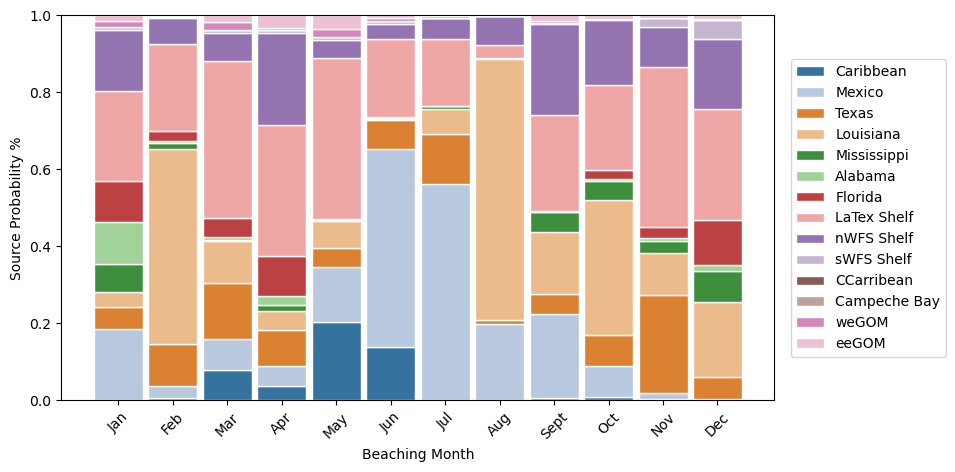

In [14]:
category_names_fig13 = group_source_region_names
# since vals are 0.9999, I have just adjusted them to exactly one, and the plot looks better this way 
results_fig13 = {(i+1): Fig13_vals.T[i]/np.sum(Fig13_vals.T[i]) for i in range(np.shape(Fig13_vals)[1])}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = sns.color_palette("tab20", 15, desat = 0.7)

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.yaxis.set_visible(True)
    ax.set_ylim(0, np.sum(data, axis=1).max())
    ax.set_ylabel("Source Probability %")
    ax.set_xlabel('Beaching Month')


    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.bar(labels, widths, bottom=starts,width = 0.9, label=colname, color=color, edgecolor='white',)

    legend = ax.legend(ncols=1, bbox_to_anchor=(1.25, 0.5), loc='right', fontsize='medium')

    return fig, ax, legend


fig, ax, legend = survey(results_fig13, category_names_fig13)

labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct', 'Nov', 'Dec']
x = [i for i in range(1, len(labels) + 1)]

plt.xticks(x, labels, rotation=45)

plt.savefig(outputgraphsDir + 'beaching_month_source_prob.png')

Nurdle Beaching Location

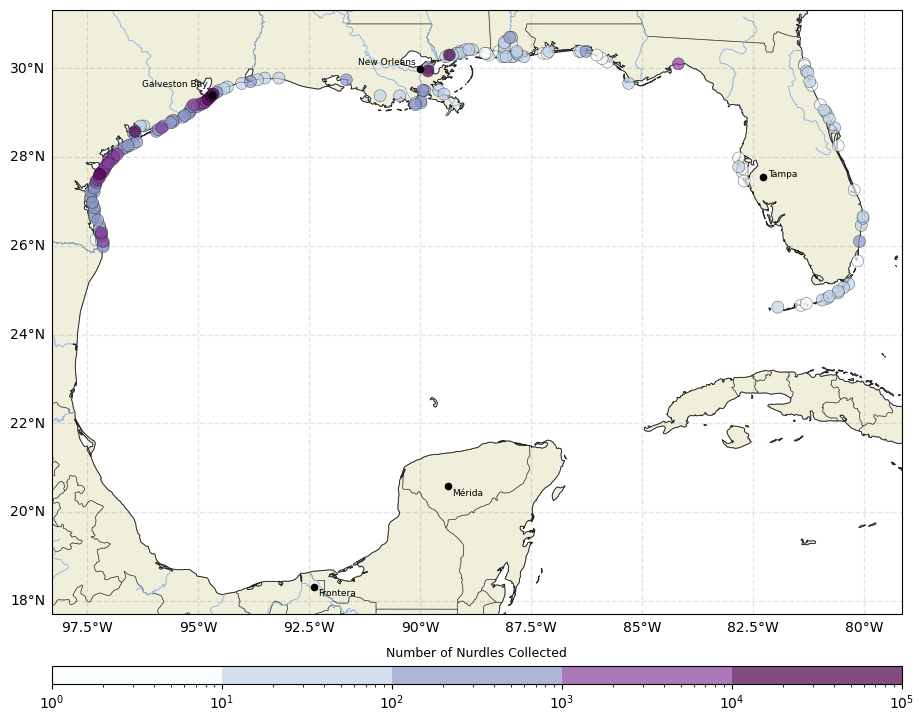

In [10]:
# plotting settings

fig = plt.figure(figsize=(9,10), constrained_layout = True)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.1, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Geospatial Features
ax.add_feature(cfeature.LAND, zorder=1,)
ax.add_feature(cfeature.COASTLINE, linewidth=0.7, zorder=1, alpha = 0.7)
ax.add_feature(cfeature.STATES, linewidth=0.5, zorder=1, alpha = 0.5)
ax.add_feature(cfeature.RIVERS, linewidth=0.7, zorder=1,  alpha = 1.0)

# Major Cities
plt.scatter(major_city_df.lons, major_city_df.lats, color = 'black', s = 20, zorder=11)
# add labels to all points
for i in range(len(major_city_df)):
    if (major_city_df.major_city_names.iloc[i] == 'New Orleans'):
        plt.text(major_city_df.lons.iloc[i]-0.11, major_city_df.lats.iloc[i]+0.05, 
             major_city_df.major_city_names.iloc[i], size = 6.5, rotation_mode =  'anchor',
             va=major_city_df.major_city_vl.iloc[i], 
             ha=major_city_df.major_city_hl.iloc[i])
    elif (major_city_df.major_city_names.iloc[i] == 'Galveston Bay'):
        plt.text(major_city_df.lons.iloc[i]-0.11, major_city_df.lats.iloc[i]+0.15, 
             major_city_df.major_city_names.iloc[i], size = 6.5, rotation_mode =  'anchor',
             va=major_city_df.major_city_vl.iloc[i], 
             ha=major_city_df.major_city_hl.iloc[i])
    else:
        plt.text(major_city_df.lons.iloc[i]+0.1, major_city_df.lats.iloc[i]-0.05, 
             major_city_df.major_city_names.iloc[i], size = 6.5, rotation_mode =  'anchor',
             va=major_city_df.major_city_vl.iloc[i], 
             ha=major_city_df.major_city_hl.iloc[i])
    
# Custom Features
num_colors = 5
cmap_n = plt.get_cmap('BuPu', num_colors)

lon_vals, lat_vals = np.meshgrid(gom_masks['lon'], gom_masks['lat'])


# nurdle
nurdles = gom_masks.nurdlecount.values
r_lat_idx, r_lon_idx = np.where(nurdles > 0.0)
r_Y, r_X, r_Z = gom_masks.lat[r_lat_idx].values, gom_masks.lon[r_lon_idx].values, nurdles[r_lat_idx, r_lon_idx] 

# replot top 25 rivers for visibility
df = {'lat': r_Y, 'lon': r_X, 'val': r_Z}
df = pd.DataFrame(df)
df = df.sort_values(by = 'val', ascending = False)
df = df.sort_values(by = 'val', ascending = True)


river = ax.scatter(df.lon, df.lat, c = df.val, s = 75, 
                   norm=colors.LogNorm(vmin=1, vmax=100000), alpha = 0.7, cmap = cmap_n, edgecolors='black', linewidths = 0.3)


axins_r = inset_axes(ax,
                    width="100%",  
                    height="3%",
                    loc='lower center',
                    borderpad=-5
                   )

axins_r.set_title('Number of Nurdles Collected', fontsize = 9)
fig.colorbar(river, cax=axins_r, orientation="horizontal", ticks=[1, 10, 100,1000, 10000,100000])
axins_r.minorticks_on()

plt.savefig(outputgraphsDir + 'nurdle_map.png')

Fig 11 GreyScaled

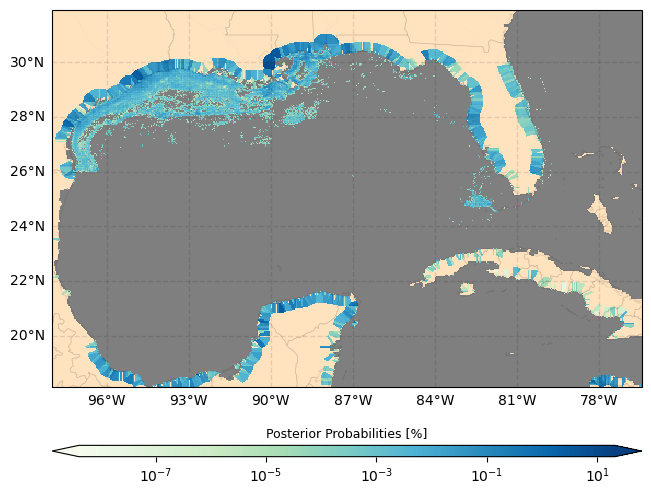

In [15]:
# plotting settings

fig = plt.figure(constrained_layout = True)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.1, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.add_feature(cfeature.STATES, linewidth=0.5, zorder=9, alpha = 0.1)
ax.add_feature(cfeature.RIVERS, linewidth=0.3, zorder=9,  alpha = 0.1)

###

lon_vals, lat_vals = np.meshgrid(gom_masks['lon'], gom_masks['lat'])


# land
_ = ax.pcolormesh(lon_vals, lat_vals, gom_masks.landmask, cmap='copper',alpha =0.5)

# posterior
within_25km_idx = np.where(~np.isnan(gom_masks.plotcoastidx))
ci25 = np.array(gom_masks.plotcoastidx.values[within_25km_idx], dtype = int)
idx_coast_mask = np.where(gom_masks.coastalmask == 1)
limgm = Figure_11[idx_coast_mask]
vals_within_25km = np.zeros( (gom_masks.dims['lat'], gom_masks.dims['lon']) )
vals_within_25km[within_25km_idx] = limgm[ci25]

Figure_11_extended = Figure_11 + vals_within_25km

f = ax.pcolormesh(lon_vals, lat_vals, Figure_11_extended, norm=colors.LogNorm(),cmap='GnBu', alpha = 1.0, )

axins_f = inset_axes(ax,
                    width="100%",  
                    height="3%",
                    loc='lower center',
                    borderpad=-5
                   )

axins_f.set_title('Posterior Probabilities [%]', fontsize = 9)
fig.colorbar(f, cax=axins_f, orientation="horizontal",extend='both')
axins_f.minorticks_off()